In [1]:
pip install transformers


     |████████████████████████████████| 1.1MB 4.9MB/s 
     |████████████████████████████████| 890kB 20.5MB/s 
     |████████████████████████████████| 1.1MB 29.8MB/s 
     |████████████████████████████████| 3.0MB 48.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=2773e42cfc390b918f95d61c38fe3f7abb7556313de352f6333633739b11a659
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install chart_studio

     |████████████████████████████████| 71kB 3.3MB/s 


In [3]:
pip install fastai

In [4]:
pip install scikit-learn

In [5]:
%tensorflow_version 2.x

In [6]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

TensorFlow 1.x selected.
1.15.2
Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
import pandas as pd
import io
import os
import json
from fastai.text import *
from fastai.metrics import *
from transformers import RobertaTokenizer

In [43]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2020,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-base 
    max_lr=1e-5,
    epochs=7,
    use_fp16=False,
    bs=4, 
    max_seq_len=256, 
    num_labels = 3,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

In [11]:
## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/DSA4")
os.listdir()

Mounted at /content/drive


['Untitled0.ipynb', 'Classification_with_RoBERTa.ipynb']

In [12]:
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data.csv
Saving training_data.csv to training_data.csv


In [13]:
df = pd.read_csv(io.StringIO(uploaded['training_data.csv'].decode('utf-8')))
df.head(3)

,id,thread_title,reply_split,classification
0,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,"Hi stao, the response of the T64fx changes dep...",irrelevant
1,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,Usually I have a Primorac Carbon and I'm offen...,irrelevant
2,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,I used T05fx before and I really appreciate th...,comparative


In [14]:
test_df = pd.read_csv(io.StringIO(uploaded['test_data.csv'].decode('utf-8')))
test_df.head(3)

,id,thread_title,reply_split
0,5f686bc8b59794ca78c70903,Butterfly Impartial XS vs 802-40 vs spinlord w...,I'm also interested.
1,5f686bc8b59794ca78c70903,Butterfly Impartial XS vs 802-40 vs spinlord w...,maybe TTD can start reviewing some sp rubbers?
2,5f686bc8b59794ca78c70903,Butterfly Impartial XS vs 802-40 vs spinlord w...,I do not know if tabletennisdaily can reiview ...


In [15]:
df = df[['reply_split','classification']]

In [16]:
test_df = test_df[['reply_split']]

In [17]:
df.head(2)

,reply_split,classification
0,"Hi stao, the response of the T64fx changes dep...",irrelevant
1,Usually I have a Primorac Carbon and I'm offen...,irrelevant


In [18]:
df.isna().sum()

reply_split       0
classification    0
dtype: int64

In [19]:
test_df.isna().sum()

reply_split    0
dtype: int64

In [20]:
#df = df.dropna(axis=0, how ='any')
#test_df = test_df.dropna(axis=0, how ='any')

In [21]:
print(df.shape,test_df.shape)

(2176, 2) (334, 1)


In [22]:
if config.testing: df = df[:5000]

In [44]:
feat_cols = "reply_split"
label_cols = "classification"

In [45]:
feat_cols1 = "reply_split"

In [46]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [47]:
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

In [48]:
roberta_tok

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [50]:
path = F"/content/gdrive/My Drive/DSA4" 
roberta_tok.save_vocabulary(path)

('/content/gdrive/My Drive/DSA4/vocab.json',
 '/content/gdrive/My Drive/DSA4/merges.txt')

In [51]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/DSA4")
os.listdir()

Mounted at /content/drive


['Untitled0.ipynb',
 'Classification_with_RoBERTa.ipynb',
 'test_data.csv',
 'training_data.csv',
 'vocab.json',
 'merges.txt']

In [52]:
# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [53]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), RobertaNumericalizeProcessor(vocab=vocab)]

In [54]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)


In [55]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [56]:
import concurrent.futures

# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

In [57]:
processor

In [58]:
# creating our databunch 
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .add_test(RobertaTextList.from_df(test_df, ".", cols=feat_cols1, processor=processor)) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)


In [59]:
data

RobertaDataBunch;

Train: LabelList (1741 items)
x: RobertaTextList
<s> Hi Ġst ao , Ġthe Ġresponse Ġof Ġthe ĠT 64 fx Ġchanges Ġdepending Ġon Ġthe Ġthe Ġblade Ġyou 're Ġusing . </s>,<s> Usually ĠI Ġhave Ġa ĠPrim or ac ĠCarbon Ġand ĠI 'm Ġoffensive Ġplayer Ġwith Ġag ressive Ġtop Ġspin . </s>,<s> I Ġused ĠT 05 fx Ġbefore Ġand ĠI Ġreally Ġappreciate Ġthe Ġgeneral Ġfeeling Ġof Ġthe ĠT 64 fx , Ġwhich Ġis Ġmore Ġsofter Ġbut Ġfaster Ġthan Ġ05 fx . </s>,<s> On Ġthe Ġother Ġhand Ġless Ġspin Ġtoo . </s>,<s> Very Ġgood Ġfor Ġblock . </s>
y: CategoryList
irrelevant,irrelevant,comparative,comparative,descriptive
Path: .;

Valid: LabelList (435 items)
x: RobertaTextList
<s> My ĠB H Ġwing Ġhas Ġa Ġlot Ġof Ġvariety Ġof Ġshots Ġpossible , Ġbut Ġat Ġthe Ġend Ġof Ġthe Ġday , Ġsofter Ġdynamic Ġrub bers , Ġor Ġslower Ġolder Ġsofter Ġrub bers Ġgive Ġme Ġmore Ġconsistency Ġin Ġlanding Ġpercentage Ġand Ġmy Ġpower Ġshots Ġon Ġthat Ġwing Ġdo Ġnot Ġlack Ġpower Ġor Ġcontrol . </s>,<s> Is k and ar </s>,<s> It Ġmay 

In [60]:
# Building the Model

In [61]:
import torch.nn as nn
from transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=3):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [62]:
roberta_model = CustomRobertaModel(num_labels=config.num_labels)

learn = Learner(data, roberta_model, metrics=[accuracy])

In [63]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.802685,0.667555,0.781609,00:41
1,0.549160,0.406574,0.843678,00:40
2,0.437588,0.336089,0.887356,00:40
3,0.288180,0.397193,0.866667,00:41
4,0.164633,0.386382,0.873563,00:40
5,0.088566,0.420515,0.873563,00:40
6,0.087301,0.423447,0.875862,00:41


In [64]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [65]:
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [66]:
# accuracy on valid
(pred_values == data.valid_ds.y.items).mean()

0.8758620689655172

In [67]:
print(learn.model)

CustomRobertaModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [68]:
learn.model.roberta.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [69]:
learn.show_results()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target,prediction
"<s> I Ġused ĠMX - S Ġon Ġback hand Ġfor Ġtwo Ġblades , Ġone Ġis Ġtim o Ġb oll Ġspirit , Ġand Ġone Ġis Ġinner force Ġlayer Ġz lc . I 've Ġalways Ġlike Ġa Ġboosted Ġh 3 Ġneo Ġ( soft ) Ġon Ġb h , Ġ37 - 38 Ġdegree , Ġproblem Ġis Ġi Ġdont Ġlike Ġthe Ġre boost ing Ġprocess Ġ, cost ly Ġand Ġthe Ġrubber Ġdont Ġlast Ġthat",irrelevant,irrelevant
"<s> i Ġwas Ġthinking Ġof Ġreplacing Ġhex er Ġh d Ġon Ġmy Ġfore hand Ġwith Ġx iom Ġo 4 Ġpro Ġor Ġas ia , but Ġas Ġi 'm Ġvery Ġpleased Ġwith Ġh d Ġand Ġi Ġcould ' nt Ġget Ġany Ġconvincing Ġinfo Ġabout Ġomega 4 Ġbeing Ġmore Ġsuitable Ġfor Ġme Ġi Ġdecided Ġand Ġordered Ġa Ġnew Ġsheet Ġof Ġh d Ġ2 Ġdays Ġago ... Ġbut Ġi Ġcould Ġnot Ġresist Ġtrying",irrelevant,irrelevant
"<s> Here 's Ġone Ġof Ġthe Ġweb Ġsites Ġthat Ġclaims Ġto Ġsell Ġ"" personal Ġrub bers "": https :// www . pro tt . v ip /"" Personal "" Ġrub bers : https :// www . pro tt . v ip / Product - List . aspx ? product type = 51 THIS Ġseems Ġto Ġbe Ġsome Ġnew Ġsort Ġof ĠDHS Ġpackaging : https :// www . pro tt .",irrelevant,irrelevant
<s> That Ġcould Ġbe Ġjust Ġbecause ĠI 'm Ġso Ġused Ġto Ġplaying Ġagainst ĠT 05 .. Ġthen Ġagain ĠI Ġsee Ġballs Ġcoming Ġoff ĠR asant Ġdo Ġsome Ġvery Ġstrange Ġthings Ġat Ġtimes Ġon Ġthe Ġbounce Ġthat ĠI Ġhaven 't Ġseen Ġhappen Ġsince Ġspeed Ġglued Ġ38 mm Ġballs Ġso ĠI 'm Ġsure Ġit 's Ġmaking Ġa Ġlot Ġof Ġspin . One Ġthing Ġis Ġthat ĠR asant Ġis Ġharder Ġto Ġcontrol Ġthan,comparative,comparative


In [70]:
preds, target = learn.get_preds()

In [71]:
preds

tensor([[6.3904e-04, 1.4151e-03, 9.9795e-01],
        [3.3693e-03, 3.5940e-03, 9.9304e-01],
        [1.6394e-03, 9.0675e-04, 9.9745e-01],
        ...,
        [1.5220e-03, 8.5772e-04, 9.9762e-01],
        [9.2903e-04, 7.2968e-04, 9.9834e-01],
        [1.3856e-03, 8.9871e-04, 9.9772e-01]])

In [72]:
target

tensor([2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 2, 2, 2, 1,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        0, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 1, 1,
        0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,

In [73]:
interpretations = ClassificationInterpretation.from_learner(learn)

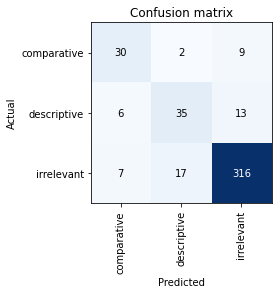

In [74]:
interpretations.plot_confusion_matrix()

In [75]:
y_test = list(target.numpy())
y_pred = preds.numpy()[:,1]

In [76]:
learn.summary()

CustomRobertaModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [171, 768]           38,603,520 True      
______________________________________________________________________
Embedding            [171, 768]           394,752    True      
______________________________________________________________________
Embedding            [171, 768]           768        True      
______________________________________________________________________
LayerNorm            [171, 768]           1,536      True      
______________________________________________________________________
Dropout              [171, 768]           0          False     
______________________________________________________________________
Linear               [171, 768]           590,592    True      
______________________________________________________________________
Linear               [171, 768]           590,592    True      
___________________________________________

In [85]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-06
Min loss divided by 10: 2.75E-07


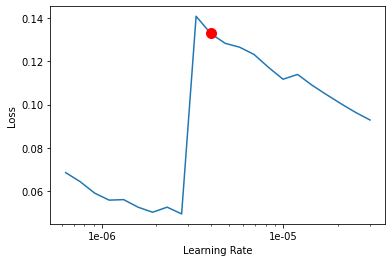

In [86]:
learn.recorder.plot(skip_end=10,suggestion=True)

In [87]:
text = "this rubber is  very bad!"
learn.predict(text)

(Category tensor(2), tensor(2), tensor([0.0020, 0.1053, 0.8927]))

In [88]:
text = "I love this rubber its very sturdy...."
learn.predict(text)

(Category tensor(1), tensor(1), tensor([0.0038, 0.9428, 0.0534]))

In [89]:
# With scale

In [90]:

def biggernum(arr):
    if arr[0] > arr[1]:
        return arr[0]
    else: 
        return arr[1]

In [91]:
def prediction(str): 
    pred = learn.predict(str)
    print('The review class is: ', pred[0], ',',  'with a scale of ','{:.2f} '.format(biggernum(pred[2].numpy()) * 100), 'out of 100.') 

In [92]:
import plotly.express as px

In [93]:
msg1 = "Not sure what quality it is..."
prediction(msg1)
pred = learn.predict(msg1)
vals = [round(biggernum(pred[2].numpy()*100), 2), round(100- biggernum(pred[2].numpy()*100),2)] 
fig = px.pie(pred, values=vals, title=msg1)
fig.show()


The review class is:  irrelevant , with a scale of  0.09  out of 100.


In [94]:
msg2 = "I like hard sponge so t05 is my favourite"
prediction(msg2)
pred = learn.predict(msg2)
vals = [round(biggernum(pred[2].numpy()*100), 2), round(100- biggernum(pred[2].numpy()*100),2)] 
fig = px.pie(pred, values=vals, title=msg2)
fig.show()

The review class is:  comparative , with a scale of  95.70  out of 100.


In [95]:
# Getting Predictions for test data

In [96]:
test_df.head(3)

,reply_split
0,I'm also interested.
1,maybe TTD can start reviewing some sp rubbers?
2,I do not know if tabletennisdaily can reiview ...


In [97]:
_, test_pred_values = get_preds_as_nparray(DatasetType.Test)

In [98]:
test_pred_values

array([2, 2, 2, 2, ..., 2, 2, 2, 2])

In [99]:
test_df["predicted_class"] = test_pred_values

In [100]:
test_df.head(10)

,reply_split,predicted_class
0,I'm also interested.,2
1,maybe TTD can start reviewing some sp rubbers?,2
2,I do not know if tabletennisdaily can reiview ...,2
3,Think they need someone that know how to play ...,2
4,I think all three of them are considered gripp...,0
5,802 40 is not a rubber with inbuilt glue effec...,2
6,So the two latter is proably a bit faster?,2
7,"I also think 802 40 is hardest, or atleast fee...",0
8,Try google and you will find alot.,2
9,Or ask at oaak tabletennis forum.,2


In [101]:
test_df.tail(10)

,reply_split,predicted_class
324,Easy to search and compares all other rubbers ...,2
325,So it seems that...,2
326,Tenergy64 (2.1) = 67g to 68g,2
327,Tenergy64 (1.9) = 63g,2
328,Tenergy05(2.1) = 70g,2
329,Tenergy05(1.9) = 66g to 68g,2
330,There is about 4g different for 2.1 and 1.9 sh...,2
331,"So after cutting it out, I assume, the differe...",2
332,3g for both side is equal to 6g.,2
333,I suppose 6g makes a SIGNIFICANT difference fo...,2


In [102]:
# Saving/Loading the model weights

In [103]:
def save_model(learner, file_name):
    st = learner.model.state_dict()
    torch.save(st, file_name) # will save model in current dir # backend is pickle 

def load_model(learner, file_name):
    st = torch.load(file_name)
    learner.model.load_state_dict(st)

# monkey patching Learner methods to save and load model file
Learner.save_model = save_model
Learner.load_model = load_model

In [104]:
save_model

<function __main__.save_model>

In [105]:
path = 'drive/My Drive/DSA4'

In [106]:
learn.save_model('mymodel.path1')

In [107]:
learn.load_model('mymodel.path1')

In [108]:
test_df = test_df[['reply_split', "predicted_class"]]

In [109]:
test_df.head(10)

,reply_split,predicted_class
0,I'm also interested.,2
1,maybe TTD can start reviewing some sp rubbers?,2
2,I do not know if tabletennisdaily can reiview ...,2
3,Think they need someone that know how to play ...,2
4,I think all three of them are considered gripp...,0
5,802 40 is not a rubber with inbuilt glue effec...,2
6,So the two latter is proably a bit faster?,2
7,"I also think 802 40 is hardest, or atleast fee...",0
8,Try google and you will find alot.,2
9,Or ask at oaak tabletennis forum.,2


In [110]:
test_df.predicted_class.unique()

array([2, 0, 1])

In [115]:
test_df.to_csv("test_results.csv")